In [11]:
import os
import datetime
import errno

import numpy as np

import deepcell
from deepcell.utils.tracking_utils import load_trks, trks_stats
from deepcell.utils.misc_utils import sorted_nicely
from deepcell.utils.tracking_utils import load_trks

import numpy as np
from skimage.measure import label
from skimage import morphology
import matplotlib.pyplot as plt

## FGBG model

## Pixel-wise model

## GNN tracking model

In [ ]:
##### Try Well C3

In [2]:
ROOT_DIR = '../track_train/attempt_2'  # TODO: Change this! Usually a mounted volume

MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))
#DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
OUTPUT_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'nuc_tracking'))

In [3]:
from deepcell.model_zoo.tracking import GNNTrackingModel

tm = GNNTrackingModel()

2021-08-26 15:31:43.495029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-26 15:31:43.521032: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2000170000 Hz
2021-08-26 15:31:43.525773: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c8e67fc9b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-26 15:31:43.525797: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-26 15:31:43.528088: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-08-26 15:31:44

In [4]:
inf_path = os.path.join(MODEL_DIR, 'TrackingModelInf')
ne_path = os.path.join(MODEL_DIR, 'TrackingModelNE')

tm.inference_model.load_weights(inf_path)
tm.neighborhood_encoder.load_weights(ne_path)

In [12]:
# Choose and load a dataset to track using the trained model

raw_images = np.load("../22956814/C3_raw_1.npy")
labeled_movie = np.load("../22956814/C3_seg_1.npy")

In [6]:
from deepcell_tracking import CellTracker

cell_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    track_length=8,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model)

In [7]:
%%time

cell_tracker.track_cells()

CPU times: user 12min 40s, sys: 16min 32s, total: 29min 13s
Wall time: 20.9 s


In [8]:
cell_tracker.y_tracked.shape

(100, 530, 530, 1)

In [9]:
track = cell_tracker.y_tracked

[0 1 2]


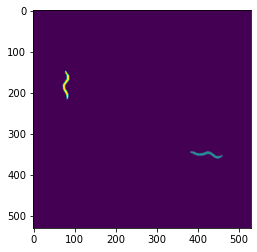

In [10]:
print(np.unique(track[1]))
plt.imshow(track[1])

unique_worm_ids:  [1, 2]
sequential ids:  [1, 2]


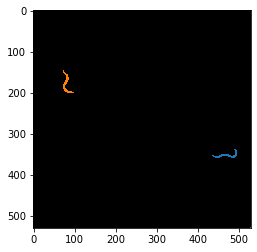

In [55]:
import gif

gif.plot_gif(track, '../22956814/gif/C3_track_1.gif')

In [56]:
# save the tracked file

np.save("../22956814/C3_track_1.npy", track)

unique_worm_ids:  [1, 2, 3]
sequential ids:  [1, 2, 3]


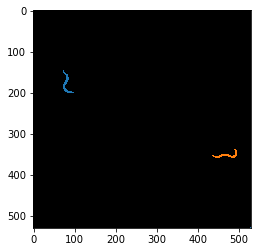

In [58]:
gif.plot_gif(np.load("../22956814/C3_seg_1.npy"), "../22956814/gif/C3_seg_1.gif")